In [ ]:
!pip install scanpy[leiden]
!pip install bbknn
!pip install harmonypy

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy.external as sce
import bbknn
import harmonypy as hm

In [ ]:
#Загрузка  данных
adata = sc.read_10x_h5("/content/5k_Mouse_Splenocytes_5p_nextgem_5k_Mouse_Splenocytes_5p_nextgem_count_sample_filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# Уровни сэмплирования
sampling_levels = [0.1, 0.25, 1.0]

def sample_umi(adata, sampling_level):
    """Сэмплирует UMI для создания батча с разной глубиной секвенирования."""
    adata_copy = adata.copy()
    if sampling_level < 1.0:
        new_counts = np.zeros(adata_copy.X.shape, dtype=np.int32)  # Initialize with the same shape
        for i in range(adata_copy.n_obs):
            umis = adata_copy.X[i].toarray()[0].astype(int)  # Преобразуем в int
            sampled_umis = np.random.binomial(umis, sampling_level)
            new_counts[i] = sampled_umis
        adata_copy.X = new_counts  # Обновляем матрицу
    adata_copy.obs['batch'] = f"sampled_{int(sampling_level * 100)}%"
    return adata_copy


# Сэмплирование
sampled_adatas = [sample_umi(adata, level) for level in sampling_levels]
adata_combined = sc.concat(sampled_adatas)


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Список всех батчей
batch_names = [f"sampled_{int(level*100)}%" for level in sampling_levels]

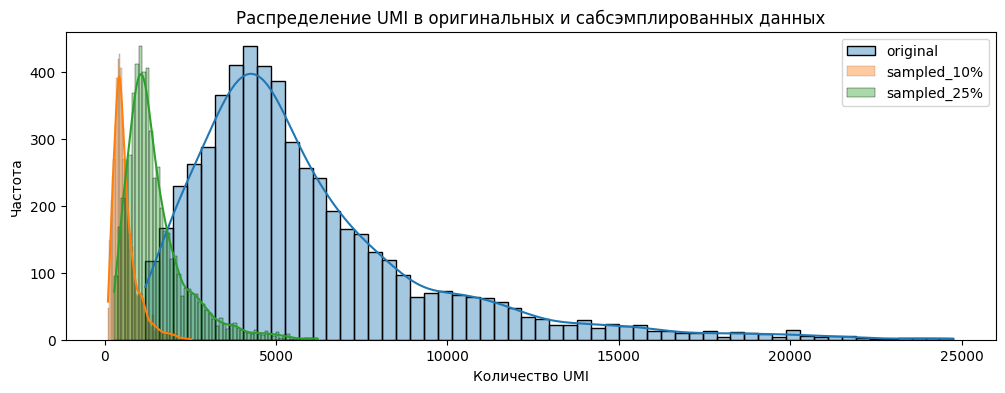

Подтверждение уменьшения UMI для первых 3-х клеток...
Батч: sampled_10%, Клетка 0: UMI до сэмплирования: 10540.0, UMI после сэмплирования: 1022.0, уменьшение в 10.31 раз.
Батч: sampled_10%, Клетка 1: UMI до сэмплирования: 3583.0, UMI после сэмплирования: 363.0, уменьшение в 9.87 раз.
Батч: sampled_10%, Клетка 2: UMI до сэмплирования: 4669.0, UMI после сэмплирования: 454.0, уменьшение в 10.28 раз.
Батч: sampled_25%, Клетка 0: UMI до сэмплирования: 10540.0, UMI после сэмплирования: 2582.0, уменьшение в 4.08 раз.
Батч: sampled_25%, Клетка 1: UMI до сэмплирования: 3583.0, UMI после сэмплирования: 868.0, уменьшение в 4.13 раз.
Батч: sampled_25%, Клетка 2: UMI до сэмплирования: 4669.0, UMI после сэмплирования: 1133.0, уменьшение в 4.12 раз.


In [ ]:
# Визуализация распределения UMI
plt.figure(figsize=(12, 4))
sns.histplot(adata.X.sum(axis=1).A.flatten(), kde=True, label='original', alpha=0.4) # Оригинальное распределение
for batch_name in batch_names:
    if batch_name != 'sampled_100%':
      sampled_adata = adata_combined[adata_combined.obs['batch'] == batch_name].copy()
      sns.histplot(sampled_adata.X.sum(axis=1).A.flatten(), kde=True, label=batch_name, alpha=0.4) # Сабсэмплированные
plt.xlabel('Количество UMI')
plt.ylabel('Частота')
plt.title('Распределение UMI в оригинальных и сабсэмплированных данных')
plt.legend()
plt.show()

# Проверка сокращения UMI для первых 3-х клеток
# Сохраняем количество UMI в оригинальных данных перед сэмплированием
total_umi_before_sampling = adata.X.sum(axis=1).A.flatten()
# Проверка сокращения UMI для первых 3-х клеток
print("Подтверждение уменьшения UMI для первых 3-х клеток...")
for batch_name in batch_names:
  if batch_name != "sampled_100%":
    sampled_adata = adata_combined[adata_combined.obs['batch'] == batch_name].copy()
    total_umi_after_sampling = sampled_adata.X.sum(axis=1).A.flatten() # Суммируем количество UMI после сэмплирования

    for i in range(min(3, sampled_adata.X.shape[0])):  # Ограничение до 3 клеток
            if total_umi_before_sampling[i] != 0:
              reduction =  float(total_umi_before_sampling[i] / total_umi_after_sampling[i])
              print(f"Батч: {batch_name}, Клетка {i}: UMI до сэмплирования: {total_umi_before_sampling[i]}, UMI после сэмплирования: {total_umi_after_sampling[i]}, уменьшение в {reduction:.2f} раз.")
            else:
                print(f"Батч: {batch_name}, Клетка {i}: UMI до сэмплирования: {total_umi_before_sampling[i]}, UMI после сэмплирования: {total_umi_after_sampling[i]}.")


исходя из этого графика, можно сделать вывод, что UMI набирались случайно и равномерно. Сэмплирование не искажает форму распределения UMI, а просто смещает его в сторону меньших значений. Это говорит о том, что UMI отбирались с одинаковой вероятностью, независимо от гена. Если бы UMI отбирались не случайно, а с весами, зависящими от генов, то мы увидели бы искажения формы распределения. То, что общая форма распределения остается похожей для всех уровней сэмплирования, указывает на то, что процедура сэмплирования была честной, и мы действительно моделируем разную глубину секвенирования. Видно, что при уменьшении уровня сэмплирования, количество UMI уменьшается, но при этом распределение смещается влево, без изменения общей формы.

Посмотрим на различие в количестве клеток, содержащих определенные Umi, между семплами

Детектирование генов:
               sampled_10%  sampled_25%  sampled_100%
St18                     7            7            25
A830018L16Rik            2            2             8
Slco5a1                 22           37           110
Eya1                    38           92           287
Paqr8                   11           23            93
Gm28836                 12           14            48
Gm4956                  78          138           267
Khdc1a                   4           14            41
Khdc1b                   4            2             7
Kcnq5                  692         1304          2548


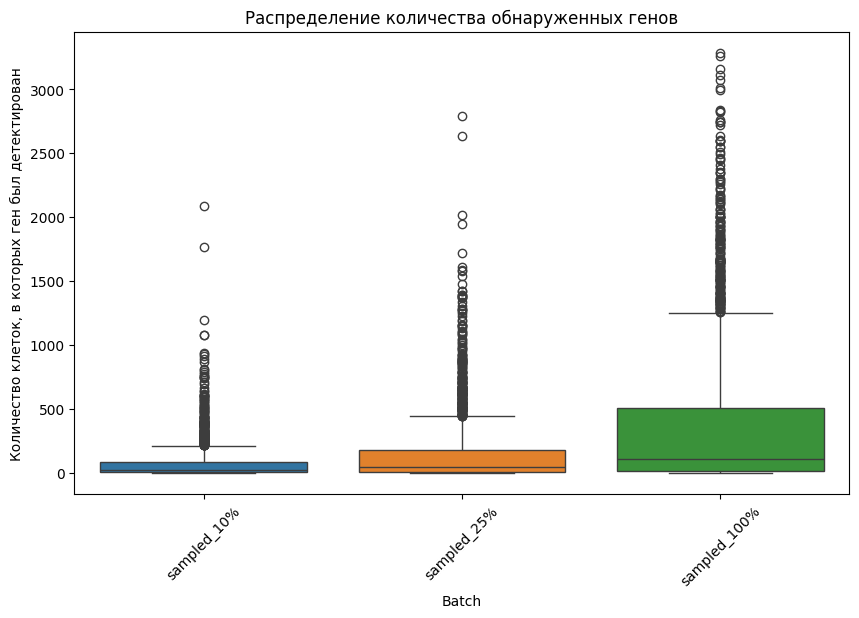

In [ ]:
def demonstrate_technical_differences(adata):

     batches = adata.obs['batch'].unique()

     # Детектирование генов
     print("Детектирование генов:")
     gene_detection_counts = {}
     for batch in batches:
        adata_batch = adata[adata.obs['batch'] == batch].copy()
        gene_detection_counts[batch] = adata_batch.X.getnnz(axis=0).tolist()
     gene_detection_df = pd.DataFrame(gene_detection_counts, index = adata.var_names)
     print(gene_detection_df.head(10))

     # Построение графика количества обнаруженных генов
     plt.figure(figsize=(10, 6))
     sns.boxplot(data=gene_detection_df)
     plt.title('Распределение количества обнаруженных генов')
     plt.xlabel('Batch')
     plt.ylabel('Количество клеток, в которых ген был детектирован')
     plt.xticks(rotation=45)
     plt.show()

demonstrate_technical_differences(adata_combined)
plt.show()

Строим распределение экспрессии конкретного гена по клеткам между батчами

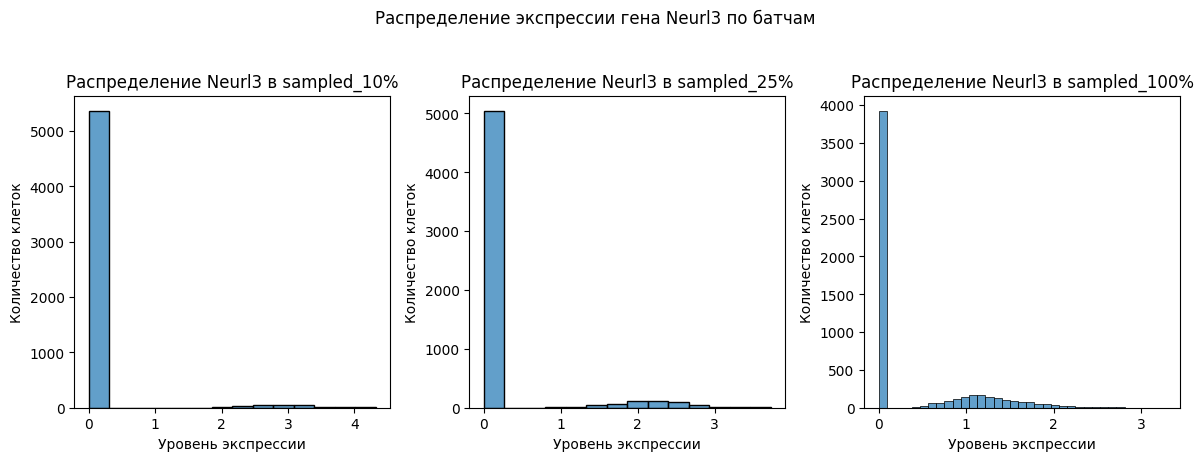

In [ ]:
def plot_gene_distribution(adata, gene_name):

    batches = adata.obs['batch'].unique()

    if gene_name not in adata.var_names:
        print(f"Error: Gene {gene_name} not found in adata.var_names.")
        return

    plt.figure(figsize=(12, 8))
    for i, batch in enumerate(batches):
        adata_batch = adata[adata.obs['batch'] == batch]
        gene_expr = adata_batch[:, gene_name].X.toarray().flatten() # берем все значения гена для всех клеток в данном батче

        plt.subplot(2, len(batches), i + 1)
        sns.histplot(gene_expr, kde=False, label = 'counts', alpha = 0.7)
        plt.title(f'Распределение {gene_name} в {batch}')
        plt.xlabel('Уровень экспрессии')
        plt.ylabel('Количество клеток')


    plt.suptitle(f'Распределение экспрессии гена {gene_name} по батчам')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


gene_to_plot = 'Neurl3'
plot_gene_distribution(adata_combined, gene_to_plot)
plt.show()